# Demonstrating MST for the 1% Census

The aims of this demonstration are:

1. to understand the MST synthesis method from a high level
2. visualise the impact of adding noise during synthesis

To do this, we will be synthesising the 1% Teaching File and following the path of a particular set of columns.

Moreover, to emphasise the importance of adding noise in achieving disclosure control,
we will focus on a pair of columns with a very small count in their two-way marginal table.

In [1]:
import base64
import binascii
import io
import itertools
import textwrap

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sbn
from IPython.display import display, HTML, Image
from mbi import Dataset, Domain, FactoredInference
from sklearn.preprocessing import OrdinalEncoder

import mst
from cdp2adp import cdp_rho

sbn.set_style("ticks")

In [2]:
def encode_data(data):
    """Use an ordinal encoder to convert categorical data."""

    encoder = OrdinalEncoder().fit(data)
    data = pd.DataFrame(encoder.transform(data).astype(int), columns=data.columns)

    return data, encoder


def load_data(path, skip=1):
    """Read in and prepare the data for synthesis."""

    data = pd.read_csv(path, skiprows=skip).drop("Person ID", axis=1)
    data, encoder = encode_data(data)

    return data, encoder


def decode_data(data, encoder):
    """Decode the data so it is interpretable."""

    return pd.DataFrame(encoder.inverse_transform(data), columns=data.columns)


def get_sparse_column_pair(data):
    """Get the column pair with the lowest two-way marginal count."""

    pair = None
    min_cell_count = np.inf
    for a, b in itertools.combinations(data.columns, r=2):
        count = data.groupby([a, b]).size().min()
        if count < min_cell_count:
            min_cell_count = count
            pair = [a, b]

    return pair


def calculate_marginal_table(data, by, encoder=None):
    """Get a marginal table for a column or set thereof."""

    if encoder is not None:
        data = data.pipe(decode_data, encoder)

    table = data.groupby(by).size().rename("count").reset_index()

    if not isinstance(by, str) and len(by) > 1:
        table = table.pivot(*by, "count")

    return table

## The MST method

Maximum Spanning Tree (MST) is a data synthesis method for accurately synthesising categorical data while preserving privacy.
The authors of MST [won the 2018 NIST competition](https://doi.org/10.29012/jpc.778) for differential privacy (DP) and data synthesis.
The team won using a variant of MST tailored to the contest dataset - extracts from the 1940 US Census.

There are three main steps to MST:

1. **Select** a collection of one- and two-way marginals from the data
2. **Measure** the marginals privately by adding a controlled amount of noise to each cell count
3. **Generate** synthetic data that attempts to match the noisy marginals

MST is a flexible, scalable method that can preserve interactions in the data beyond those it measures.
This accuracy for latent relationships comes in the **generate** step which employs the [`Private-PGM`](http://proceedings.mlr.press/v97/mckenna19a.html) method.
`Private-PGM` represents the noisy marginals as a graph with nodes and edges.

Since MST is a _differentially private_ synthesis method, we must also specify a privacy budget.
The variant of DP used in MST requires two parameters, $\epsilon > 0$ and $0 < \delta << \epsilon$.
These parameters control the amount of noise added to marginals, and the pseudo-randomness of the selection process.

Choosing $\delta$ is relatively straightforward so long as it is smaller than $\frac{1}{N}$ where $N$ is the length of the dataset to be synthesised.
Choosing the primary privacy budget $\epsilon$ is much more nuanced and broadly determines how accurate the synthetic data may be.
While larger values are commonly used in practice, the academic standard is $0.01 \approx \ln(1.1) \le \epsilon \le \ln(3) \approx 1.1$.

For this demonstration, we take $\epsilon = 1$ and
$\delta = 10 ^ {- ceil\left(\log_{10} N\right)} = 10 ^ {-6}$, where $ceil$ is the ceiling function.

In [3]:
data, encoder = load_data("main.csv")
a, b = pair = get_sparse_column_pair(data)

np.random.seed(0)
epsilon, delta = 1, 10 ** -np.ceil(np.log10(len(data)))
dataset = Dataset(data, Domain.fromdict(data.nunique().to_dict()))

In [4]:
rho = cdp_rho(epsilon, delta)
sigma = np.sqrt(3 / (2 * rho))
cliques = [(col,) for col in dataset.domain]
log1 = mst.measure(dataset, cliques, sigma)
dataset, log1, undo_compress_fn = mst.compress_domain(dataset, log1)

cliques = mst.select(dataset, rho / 3.0, log1, cliques=[tuple(pair)])
log2 = mst.measure(dataset, cliques, sigma)

engine = FactoredInference(dataset.domain, iters=5000)
est = engine.estimate(log1 + log2)
synth = undo_compress_fn(est.synthetic_data())

## The 1% Census

One of the outputs from the 2011 Census in England and Wales is the
[Microdata Teaching File](https://www.ons.gov.uk/census/2011census/2011censusdata/censusmicrodata/microdatateachingfile).
This file contains a 1% sample of the person records from the Census;
all records are anonymised and chosen at random.
Excluding the person ID, the data comprises 17 columns and 569,741 rows.

The primary purpose of the teaching file is an educational tool,
but it also offers up a glance at what genuine Census microdata look like.
Using this dataset to demonstrate the MST method seems sensible then,
given its previous applications to census data.

Below is a snapshot of the original data,
and beneath that is a similar snippet of the synthetic dataset.

While it may seem like we are skipping ahead,
these snippets make clear what our end goal looks like.
That is, a synthetic dataset that looks quite like the real thing.

In [5]:
data.pipe(decode_data, encoder).head()

,Region,Residence Type,Family Composition,Population Base,Sex,Age,Marital Status,Student,Country of Birth,Health,Ethnic Group,Religion,Economic Activity,Occupation,Industry,Hours worked per week,Approximated Social Grade
0,E12000001,H,2,1,2,6,2,2,1,2,1,2,5,8,2,-9,4
1,E12000001,H,5,1,1,4,1,2,1,1,1,2,1,8,6,4,3
2,E12000001,H,3,1,2,4,1,2,1,1,1,1,1,6,11,3,4
3,E12000001,H,3,1,2,2,1,2,1,2,1,2,1,7,7,3,2
4,E12000001,H,3,1,1,5,4,2,1,1,1,2,1,1,4,3,2


In [6]:
synth.df.pipe(decode_data, encoder).head()

,Region,Residence Type,Family Composition,Population Base,Sex,Age,Marital Status,Student,Country of Birth,Health,Ethnic Group,Religion,Economic Activity,Occupation,Industry,Hours worked per week,Approximated Social Grade
0,E12000003,H,5,1,1,1,1,1,1,1,1,2,-9,-9,-9,-9,-9
1,W92000004,H,5,1,1,4,1,2,1,1,1,1,1,5,3,3,3
2,E12000007,H,2,1,1,8,2,2,1,1,1,1,5,5,3,-9,2
3,W92000004,H,2,1,1,6,2,2,1,3,1,2,5,9,10,-9,2
4,W92000004,H,2,1,2,2,1,1,1,1,1,1,6,6,11,-9,3


## Our pair of columns

Our demonstration follows the trajectory of two columns in the teaching file, `Population Base` and `Marital Status`.

`Population Base` describes the individual's residency:
  1. Usual resident
  2. Student living away from home during term-time
  3. Short-term resident

`Marital Status` describes the individual's marital status:
  1. Single (never married or never registered a same-sex civil partnership) 
  2. Married or in a registered same-sex civil partnership 
  3. Separated but still legally married or separated but still legally in a same-sex civil partnership 
  4. Divorced or formerly in a same-sex civil partnership which is now legally dissolved 
  5. Widowed or surviving partner from a same-sex civil partnership

These columns are heavily unbalanced in the data with 98% of individuals being usual residents,
and 85% of individuals either being single or in a legally binding relationship, i.e., married or in a registered same-sex civil partnership:

In [7]:
def side_by_side(*dfs):
    html = '<div style="display:flex; justify-content:center">'
    for df in dfs:
        html += '<div style="margin-right: 4em">'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

In [8]:
tables = []
for col in pair:
    table = calculate_marginal_table(data, col, encoder)
    table["proportion"] = (table["count"] / table["count"].sum()).round(4)
    tables.append(table.set_index(col))

side_by_side(*tables)

,count,proportion
Population Base,,
1,561040,0.9847
2,6730,0.0118
3,1971,0.0035
,count,proportion
Marital Status,,
1,270999,0.4757
2,214180,0.3759
3,11951,0.0210
4,40713,0.0715


However, we chose these columns because they also have a two-way marginal table with some very low counts:

In [9]:
def center_frame(df):
    """Render a dataframe in the center of the page."""

    html = '<div style="display:flex; justify-content:center">'
    html += df.to_html()
    html += "</div>"

    display(HTML(html))

In [10]:
center_frame(calculate_marginal_table(data, pair, encoder))

Marital Status,1,2,3,4,5
Population Base,,,,,
1,262807,213777,11930,40664,31862
2,6684,28,8,9,1
3,1508,375,13,40,35


Typically, data owners might be hesistant to disclose information like this,
since there is only one individual in the data who is both a student and widowed.
In the case of the 1% Teaching File, the data is so granular that reidentification of this individual is incredibly small.

However, in a more fine-grained, confidential dataset, this would be a problem.

## Adding noise

To ensure the privacy of the individuals in the dataset, MST adds noise to all of these counts.
In MST, the noise is Gaussian and centred on zero.
The standard deviation of the noise distribution is determined by the privacy budget and how many measurements are taken.

MST measures all 17 one-way marginals and a selection of two-way marginals.
One third of the privacy budget is spent randomly selecting these two-way marginals.

For $\epsilon = 1$ and $\delta = 10^{-6}$, MST adds $\mathcal{N}(0, 32.36)$ noise to the one-way marginal tables.

In [11]:
weights = np.ones(len(data.columns))
weights /= np.linalg.norm(weights)

assert round(sigma / weights[0], 2) == 32.36

MST selects enough two-way marginals to connect all the columns using a graphical representation.
In this representation, columns are nodes and an edge on the graph indicates the selection of the two-way marginal between the nodes.

As such, MST must measure a minimum of 16 two-way marginals to form a minimum spanning tree of the column nodes.
In practice, the final graph is not always a tree and may contain triangles. Here, this is not the case.

For our example, MST adds $\mathcal{N}(0, 31.39)$ noise to each two-way marginal's cell counts.

In [12]:
weights = np.ones(len(data.columns) - 1)
weights /= np.linalg.norm(weights)

assert round(sigma / weights[0], 2) == 31.39

## Generating the synthetic data

With the marginals selected and measured (with added noise), they can be passed to the `Private-PGM` method to create tabular data.
In short, `Private-PGM` attempts to find a data distribution that matches the noisy marginals by solving an optimisation problem.

### Mapping out the synthesis

The synthetic dataset is generated by traversing a directed acyclic graph of the selected marginals,
and sampling as need from the estimated distribution.

The figure below shows the graph for this synthesis, showing how the generation was performed.

Each column is represented as a node, and an edge between two nodes indicates that their two-way marginal
was selected for synthesis. The direction of an edge `(a, b)` indicates that the column `a` is used to
synthesise column `b`.

This graph shows that `Industry` was synthesised first with no dependent columns.
Then the synthetic `Industry` column was used to synthesise `Occupation`, and so on.

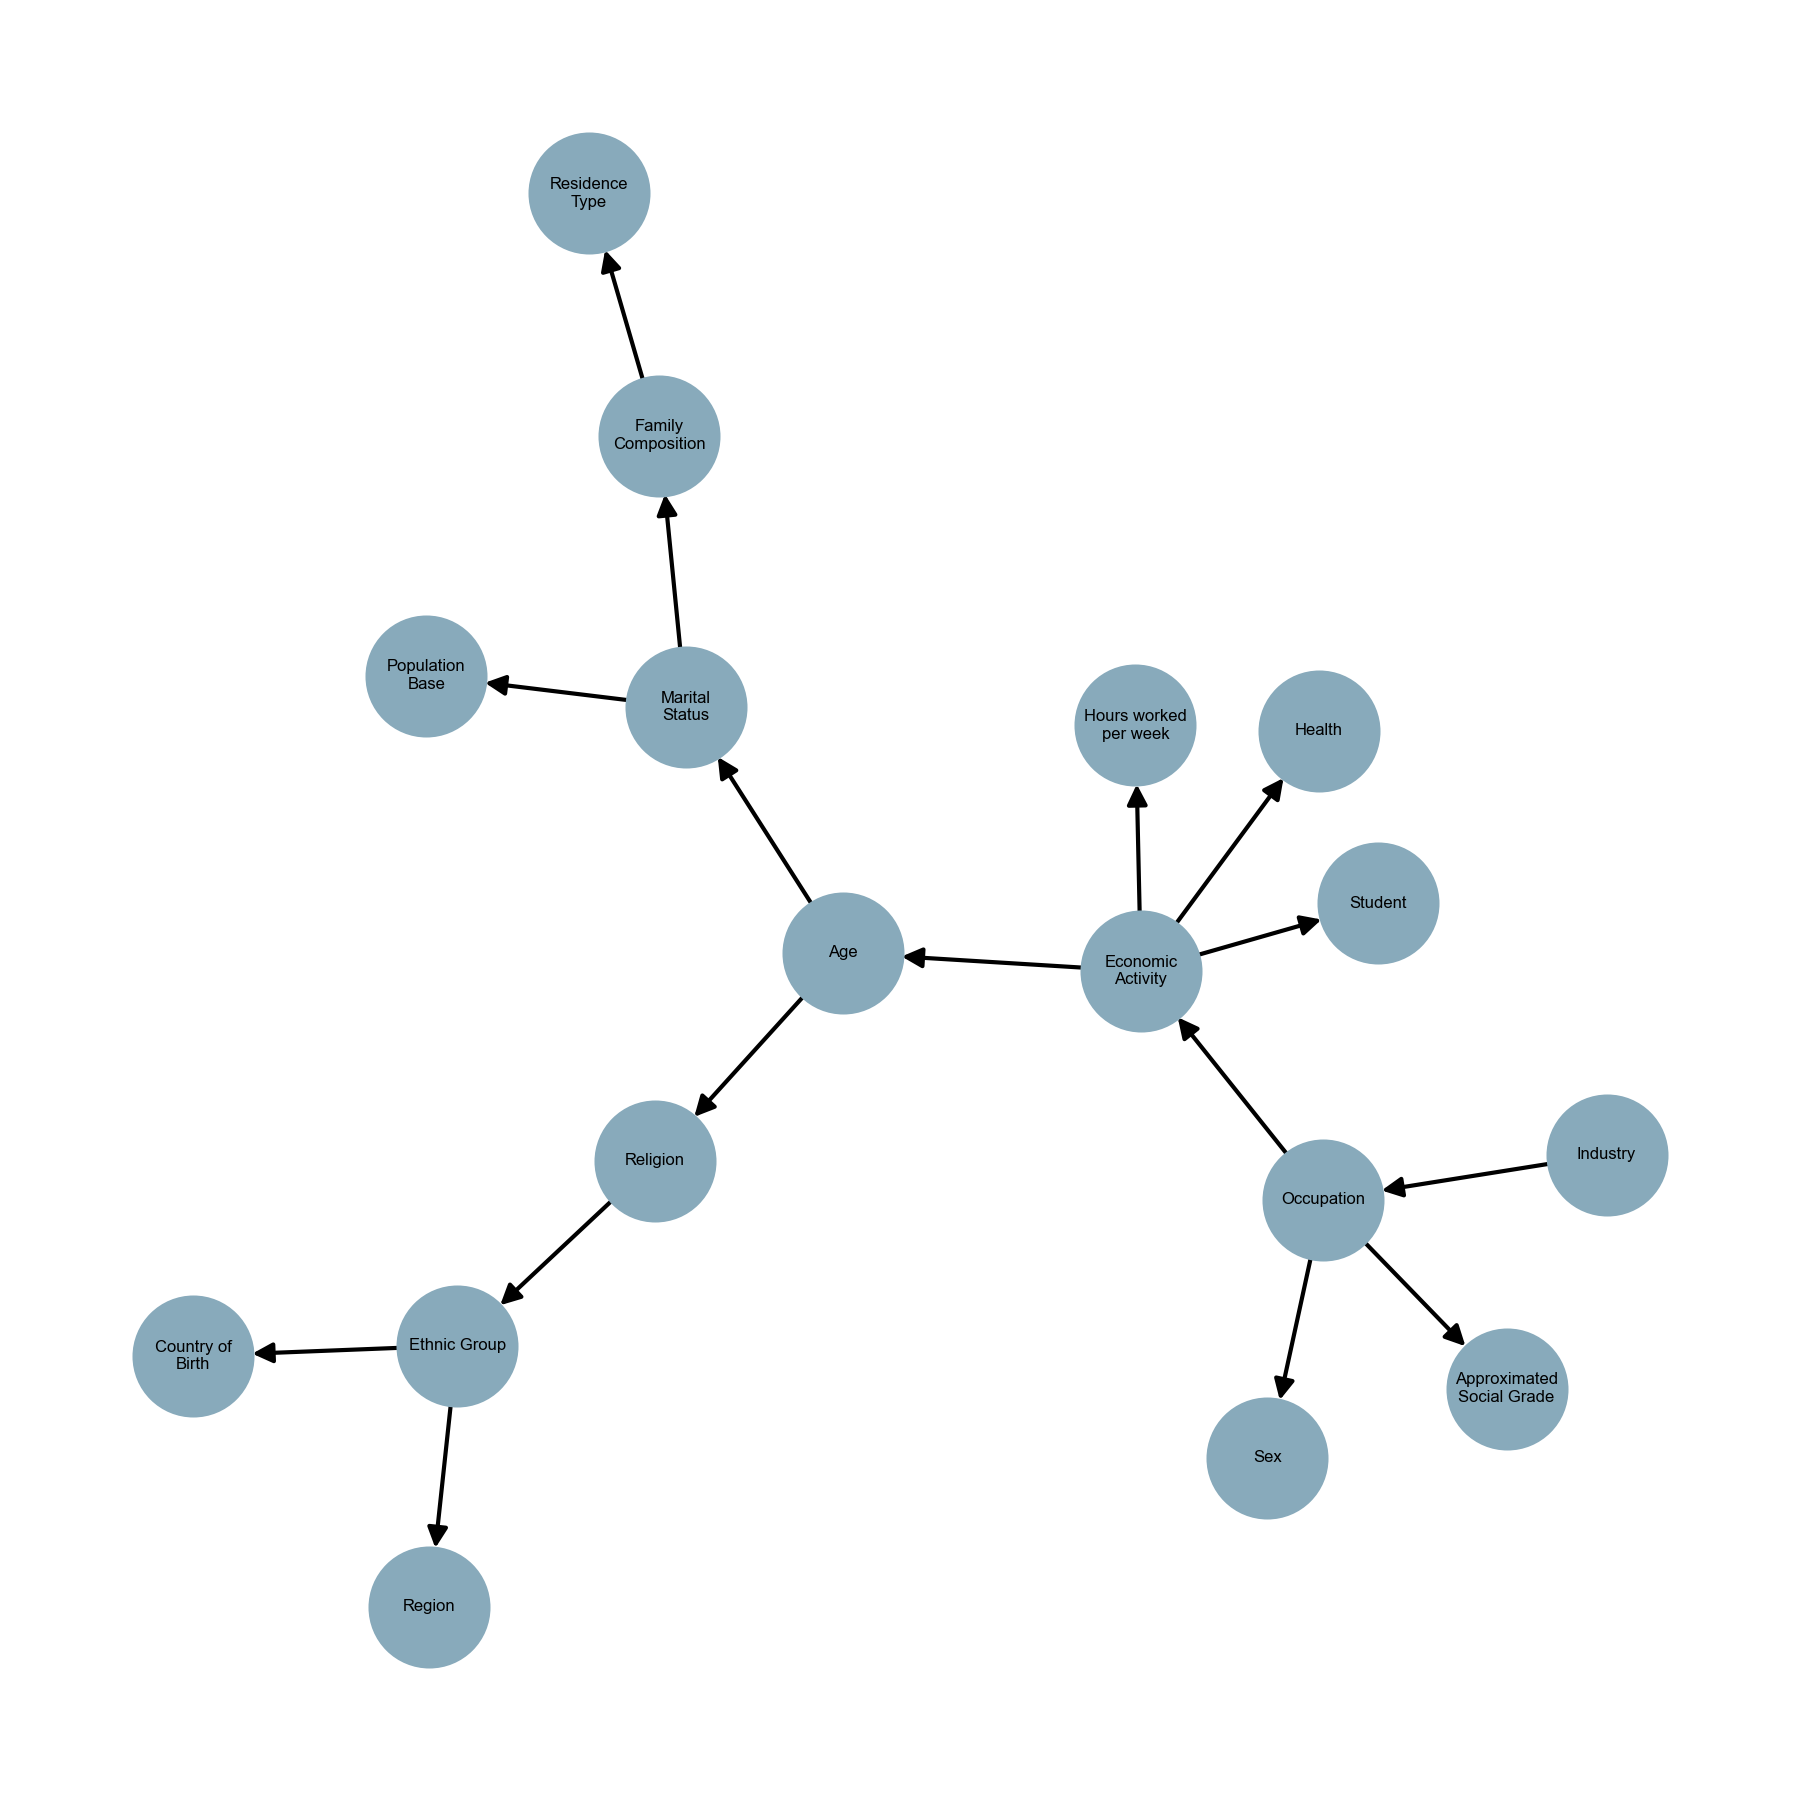

In [13]:
ordered_cliques = [
    sorted(clique, key=est.elimination_order[::-1].index) for clique in cliques
]

wrapped_cliques = [
    tuple(textwrap.fill(col, 12) for col in clique) for clique in ordered_cliques
]

graph = nx.DiGraph()
graph.add_edges_from(wrapped_cliques)
pos = nx.nx_agraph.graphviz_layout(graph, root=est.elimination_order[-1])

with io.BytesIO() as sio:
    fig, ax = plt.subplots(dpi=300, figsize=(6, 6))
    nx.draw(graph, pos, ax=ax, with_labels=True, node_size=800, node_color="#8ab", font_size=4)

    plt.tight_layout()
    fig.canvas.print_png(sio)
    img = binascii.b2a_base64(sio.getvalue())

plt.close()
display(Image(base64.b64decode(img)))

In [14]:
def get_noisy_one_way(log1, col):
    """Get the noisy marginal table for a column."""

    noisy = (
        pd.DataFrame(
            {
                "noisy_count": next(
                    counts for _, counts, _, clique in log1 if clique == (col,)
                )
            }
        )
        .rename_axis(index=col)
        .reset_index()
    )

    return noisy


def compare_one_ways(data, log1, synth, col):
    """Get a table comparing all the various one-way tables."""

    original = data.pipe(calculate_marginal_table, col).rename(
        {"count": "observed_count"}, axis=1
    )
    noisy = get_noisy_one_way(log1, col)
    synthetic = synth.df.pipe(calculate_marginal_table, col).rename(
        {"count": "synthetic_count"}, axis=1
    )

    comparison = original.merge(noisy, on=col).merge(synthetic, on=col).set_index(col)
    comparison.index += 1

    return comparison


def plot_one_way_comparison(data, log1, synth, col):
    """Make a faceted bar plot of the various one-way counts."""

    table = (
        compare_one_ways(data, log1, synth, col)
        .unstack()
        .reset_index()
        .replace("_count", "", regex=True)
    )
    table.columns = ["Origin", col, "Count"]

    grid = sbn.FacetGrid(table, col=col, hue="Origin", palette="crest", sharey=False)
    grid.map(sbn.barplot, "Origin", "Count", order=table["Origin"].unique())
    grid.set(xlabel="")

    for ax in grid.axes.ravel():
        for p in ax.patches:
            value = p.get_height()
            if np.isnan(value):
                continue
            if int(value) == value:
                value = int(value)
            else:
                value = round(value, 2)

            ax.annotate(
                f"{value:,}",
                (p.get_x() + p.get_width() / 2.0, p.get_height()),
                ha="center",
                va="center",
                xytext=(0, -10),
                textcoords="offset points",
                fontsize="small",
                color="#eee",
                # rotation=90,
            )

    return grid

## Comparing the marginal counts

### One-way marginals

To demonstrate the impact of adding noise to the marginal tables, consider the tables below,
which show the observed, noisy and synthesised counts for each our columns of interest.

In [15]:
side_by_side(compare_one_ways(data, log1, synth, a), compare_one_ways(data, log1, synth, b))

,observed_count,noisy_count,synthetic_count
Population Base,,,
1,561040,561012.364080,560993
2,6730,6647.393075,6730
3,1971,1992.149094,2002
,observed_count,noisy_count,synthetic_count
Marital Status,,,
1,270999,270970.273975,270944
2,214180,214115.907498,214146
3,11951,11939.742629,11948
4,40713,40718.058973,40739


We can see that for this privacy budget and this particular run of MST, these counts are all rather close. Success!

However, accurately recreating individuals columns is a relatively low bar for data synthesis.

In [16]:
def get_noisy_two_way(log2, pair, domain):
    """Get the noisy marginal table for a pair of columns."""

    a, b = pair
    shape = domain.project(pair).shape

    noisy = pd.DataFrame(
        next(counts for _, counts, _, clique in log2 if clique == tuple(pair)).reshape(
            shape
        )
    ).rename_axis(index=a, columns=b)

    noisy.index += 1
    noisy.columns += 1

    return noisy

In [17]:
original_pair = calculate_marginal_table(data, pair, encoder)
noisy_pair = get_noisy_two_way(log2, pair, dataset.domain)
synthetic_pair = calculate_marginal_table(synth.df, pair, encoder)

tables = (original_pair, noisy_pair, synthetic_pair)

vmin = np.log(max(1, min(x.min().min() for x in tables)))
vmax = np.log(max(x.max().max() for x in tables))

### Two-way marginals

The figures below show the marginal table for our pair of columns for the original data, its noisy counterpart, and the synthetic dataset.
The colour map indicates the count in each cell, and is consistent across the figures.

From these figures we can see that the larger counts are less affected by the noise and appear to be very accurately preserved,
which makes sense - they carry a lower disclosure risk.
The smaller counts, especially the unique individual in the original data, however, are perturbed to a much greater effect.

Looking at the noisy table, we can see that the Gaussian noise has actually pushed some
counts below zero.
The generate step of MST considers the one-way marginal table and the amount of noise added to form the noisy counts, allowing the synthetic data to still resemble the original.

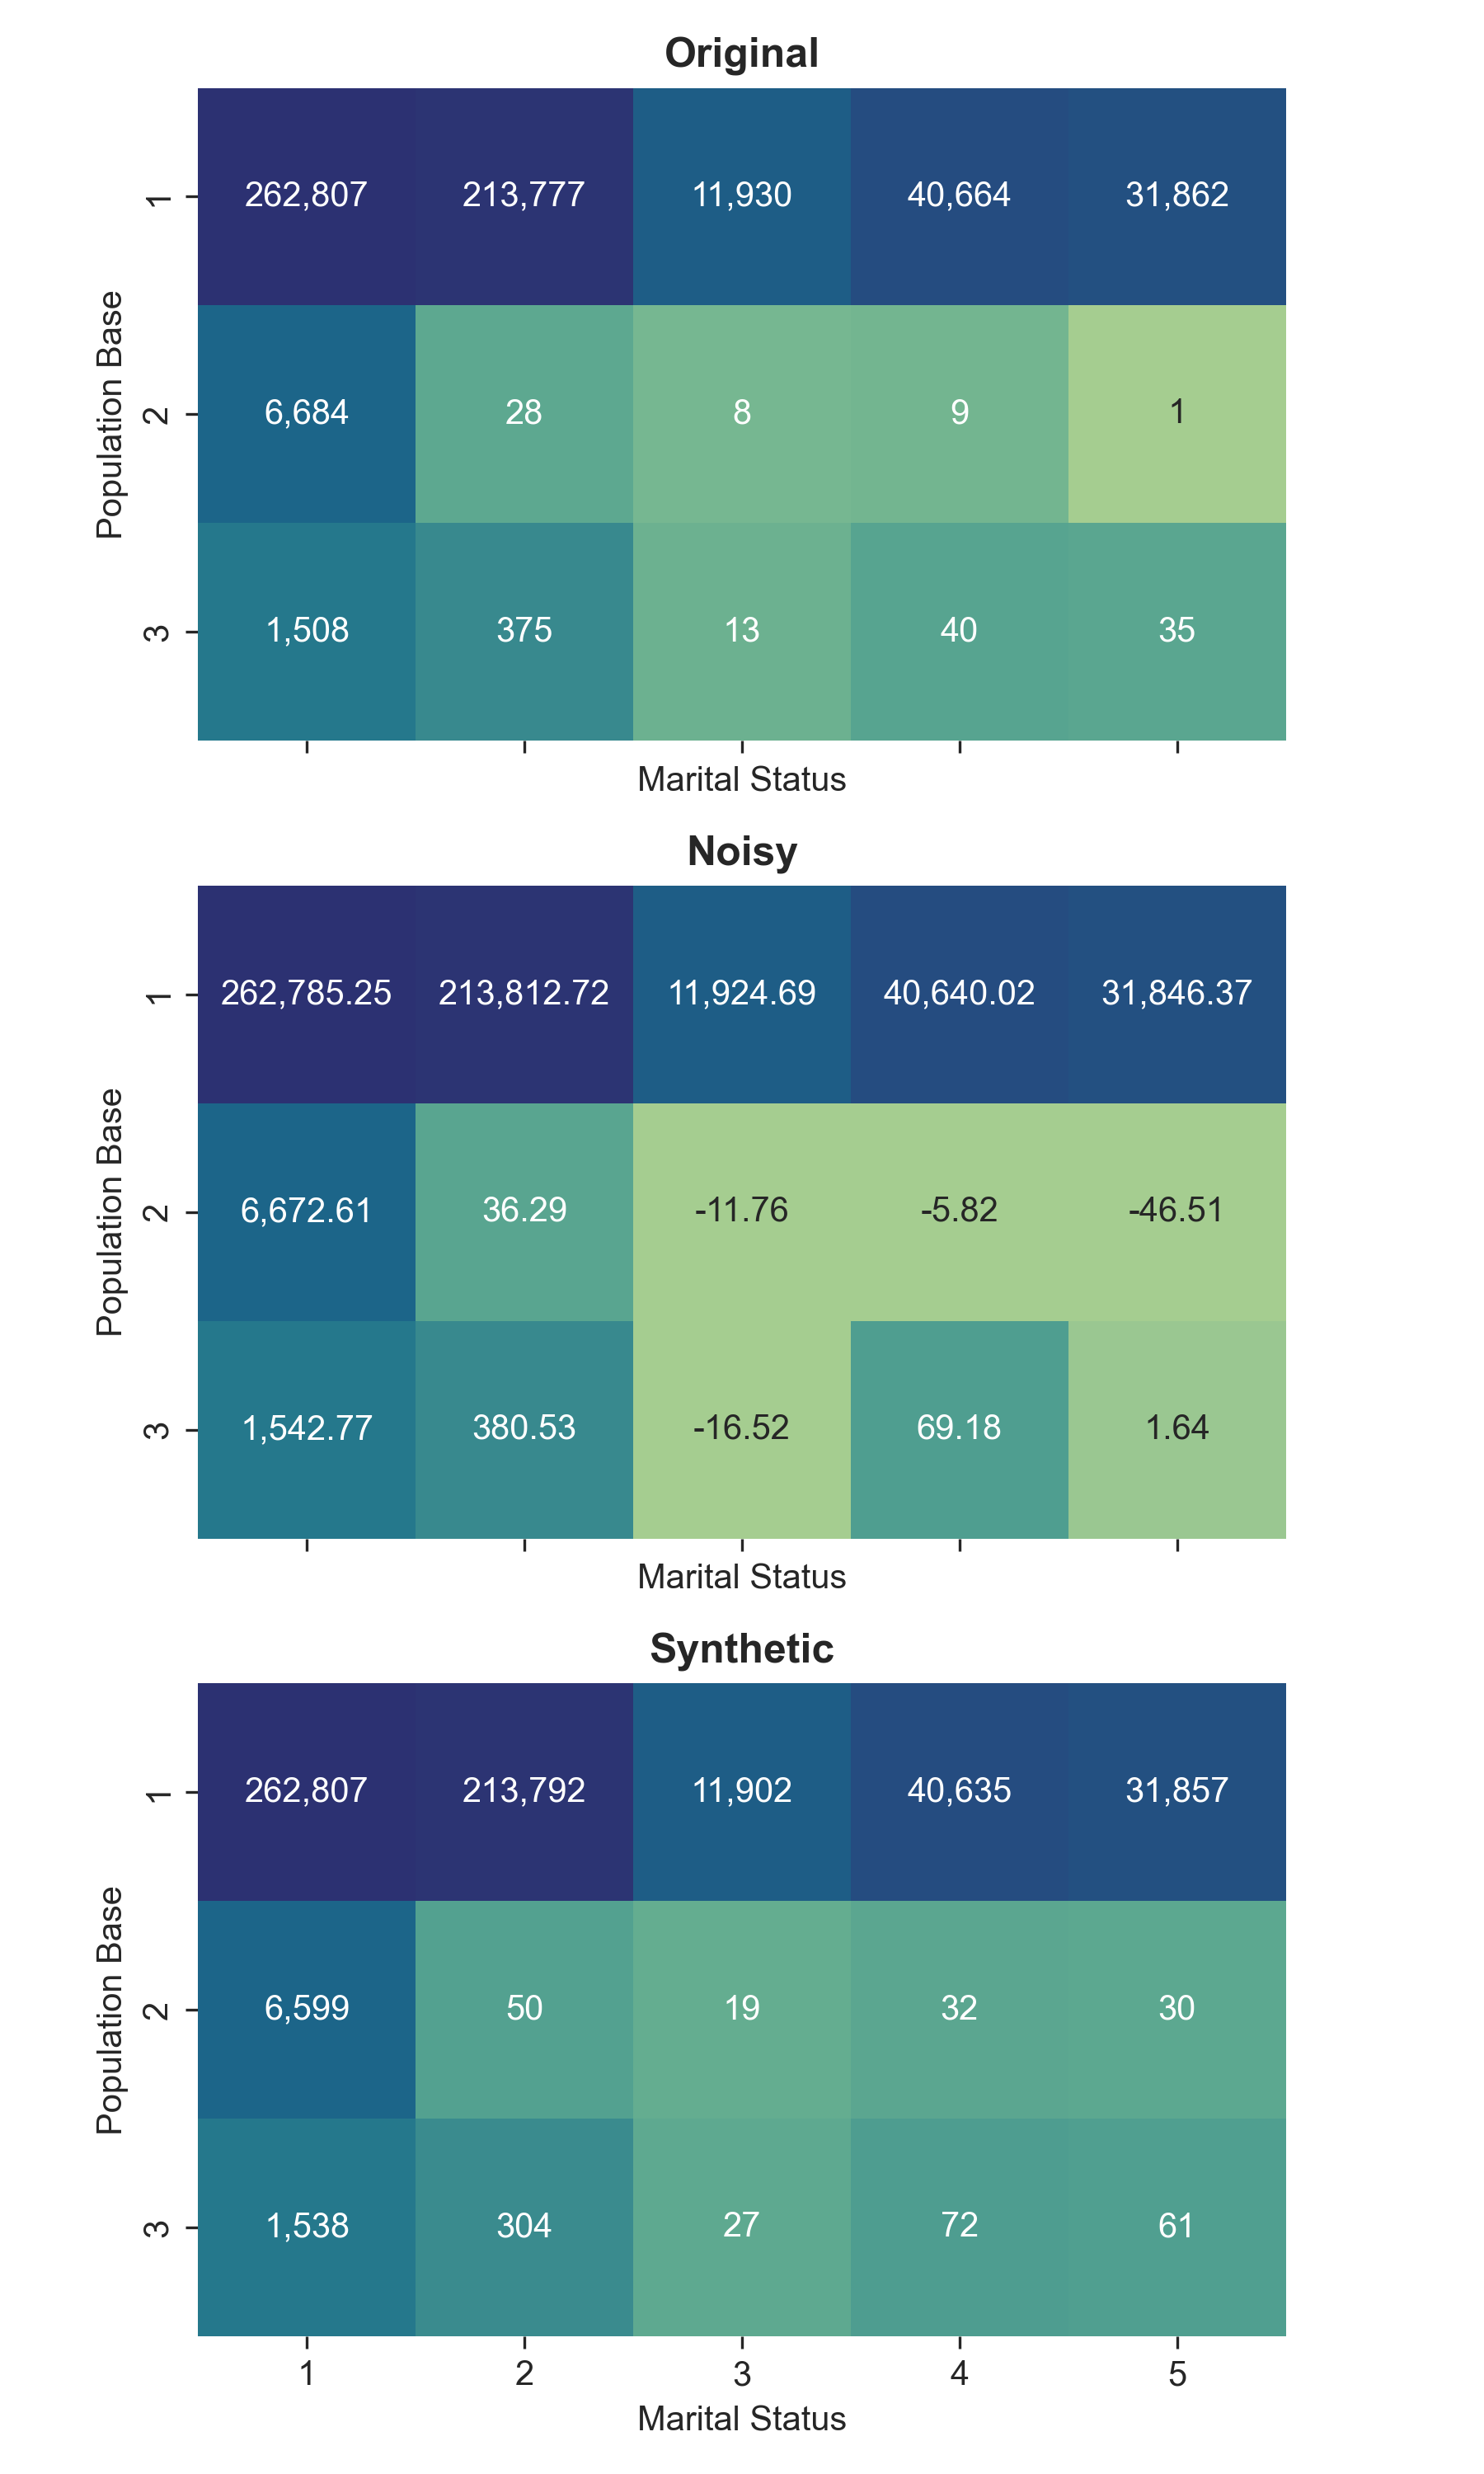

In [18]:
with io.BytesIO() as bio:
    fig, axes = plt.subplots(nrows=3, dpi=300, figsize=(6, 10), sharex=True)

    for name, table, ax in zip(("Original", "Noisy", "Synthetic"), tables, axes):
        log_table = table.copy()
        log_table[table < 0] = 1
        log_table = np.log(log_table)

        sbn.heatmap(
            log_table,
            annot=table.round(2),
            fmt=",",
            square=True,
            vmin=vmin,
            vmax=vmax,
            cbar=False,
            cmap="crest",
            ax=ax,
        )

        ax.set_title(name, fontdict={"weight": "bold"})
        
    plt.tight_layout()

    fig.canvas.print_png(bio)
    img = binascii.b2a_base64(bio.getvalue())

plt.close()
display(Image(base64.b64decode(img)))